# Initial stuff

In [1]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import pandas as pd
import numpy as np
import math
from itertools import product
from scipy.stats import entropy, beta
from scipy.special import loggamma, digamma, gamma

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


Now we need to define a bunch of metrics. These are copied-and-pasted from the repo.

In [3]:
def kl(p, q):
    """
    :param p: posterior
    :param q: prior
    :return:
    """
    return entropy([p, 1-p], [q, 1-q], base=2)

def exp10(x):
    return 1 - (10 ** (-1 * x))

def exp(b, x):
    return 1 - (b ** (-1 * x))

def kl_util(p, q):
    """
    :param p: posterior
    :param q: prior
    :return:
    """
    return exp10(entropy([p, 1-p], [q, 1-q], base=2))

def entropy_reduction(p, q):
    """
    :param p: posterior
    :param q: prior
    :return: Absolute value of entropy reduction
    """
    return abs(entropy([q, 1-q], base=2) - entropy([p, 1-p], base=2))

def bayes_factor(p, q):
    """
    :param p: posterior
    :param q: prior
    :return: absolute value of log of bayes factor
    """
    if p == 1 and q == 1 or p == 0 and q == 0:
        return 1
    else:
        return (np.float64(p) / (1-p)) * (np.float64(1-q) / q)

def log_bayes_factor(p, q):
    """
    :param p: posterior
    :param q: prior
    :return: absolute value of log of bayes factor
    """
    if p == 1 and q == 1 or p == 0 and q == 0:
        return 0
    else:
        return abs(np.log10(bayes_factor(p, q)))

def bf_utility_polar(p, q):
    """
    :param p: posterior
    :param q: prior
    """
    if p > q:
        p = 1 - p
        q = 1 - q
    return 1 - bayes_factor(p, q)

def bf_utility_multi_avg(p_list, q_list):
    """
    Note: This equals bf_utility_polar for 2-alt questions, but doesn't work when there are >2 alts.
    For example, if the i^{th} alternative is always 0, that still brings down the average.
    :param p_list:
    :param q_list:
    :return:
    """
    utils = []
    for p, q in zip(p_list, q_list):
        utils.append(bf_utility_polar(p, q))
    return np.mean(utils)

def bf_utility_multi_weighted_avg(p_list, q_list):
    """
    Note:
    :param p_list:
    :param q_list:
    :return:
    """
    utils = []
    for p, q in zip(p_list, q_list):
        utils.append(p * bf_utility_polar(p, q))
    return sum(utils)


def posterior_distance(p):
    """
    :param p: posterior
    :return: How far on a scale of 0 to 1 is p from 0.5
    """
    return 2 * abs(0.5 - p)

def prior_posterior_distance(p, q):
    """
    :param p: posterior
    :param q: prior
    :return: Distance between p and q
    """
    return abs(p - q)

def kl_dirichlet(Q, P):
    """
    :param Q: posterior params for dirichlet dist.
    :param P: prior params for dirichlet dist.
    Compute KL(Q; P) divergence of 2 dirichlet distributions with parameters Q and P.
    As usual, with KL(Q; P) Q represents the posterior, and P the prior.
    When these are beta distributions, Q[0] = \alpha, Q[1] = \beta.
    """
    return loggamma(sum(Q)) - loggamma(sum(P)) + \
        sum([loggamma(p) - loggamma(q) for p, q in zip(P, Q)]) + \
        sum([(q - p) * (digamma(q) - digamma(sum(Q))) for p, q in zip(P, Q)])


def kl_util_dirichlet(Q, P):
    """
    :param Q: posterior params for dirichlet dist.
    :param P: prior params for dirichlet dist.
    Compute KL(Q; P) divergence of 2 dirichlet distributions with parameters Q and P.
    As usual, with KL(Q; P) Q represents the posterior, and P the prior.
    When these are beta distributions, Q[0] = \alpha, Q[1] = \beta.
    """
    return exp(2, kl_dirichlet(Q, P))

def entropy_dirichlet(P):
    """
    Compute Entropy H(P) of a dirichlet distribution with parameters P.
    When P is a beta distributions, P[0] = \alpha, P[1] = \beta.
    Note: Differential entropy (i.e. continuous generalization of entropy) can be negative:
    Read more: https://en.wikipedia.org/wiki/Differential_entropy
    https://en.wikipedia.org/wiki/Beta_distribution#Quantities_of_information_(entropy)
    """
    a0 = sum(P)
    return math.log(math.prod([gamma(a) for a in P]) / gamma(a0)) \
           + (a0 - len(P)) * digamma(a0) \
           - sum([(p - 1) * digamma(p) for p in P])


def entropy_change_dirichlet(P, Q):
    """
    :param P: prior params for dirichlet dist.
    :param Q: posterior params for dirichlet dist.
    :return: Entropy change
    """
    return abs(entropy_dirichlet(P) - entropy_dirichlet(Q))

def beta_bayes_factor(P, Q):
    return math.log(
        abs(P[0] - Q[0])
        + abs(P[1] - Q[1])
        + 2
        )

def beta_bayes_factor_util(P, Q):
    return exp(2, beta_bayes_factor(P, Q))

def beta_belief_change(P, Q):
    return abs(
        sum(P) - sum(Q)
    )


In [4]:
kl_util(0.1, 0)

1.0

# Plotting first-order beliefs

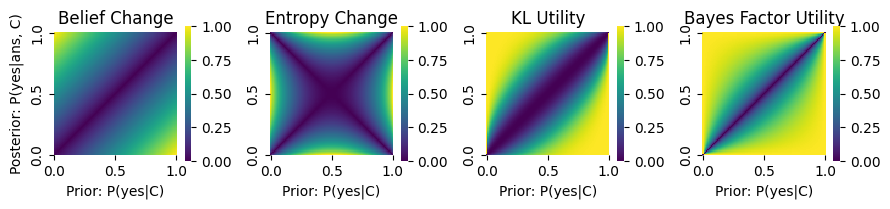

In [ ]:
def make_df_for_heatmap(f):
    n = 100
    priors = np.arange(0, 1+1/n, 1/n)
    posteriors = np.arange(0, 1+1/n, 1/n)
    array = np.zeros((n+1, n+1))
    for i, q in enumerate(priors):
        for j, p in enumerate(posteriors):
            array[j][i] = f(p, q)

    df = pd.DataFrame(array, index=priors, columns=posteriors)
    return df

def make_heatmap(df, ax, metric, min, max, cmap="viridis"):
    g = sns.heatmap(
        df,
        ax=ax,
        vmin=min,
        vmax=max,
        xticklabels=50,
        yticklabels=50,
        cmap=cmap,
        square=True,

        cbar_kws={'shrink': 0.5}
        )
    g.invert_yaxis()
    g.set_xlabel("Prior: P(yes|C)")
    g.set_ylabel("Posterior: P(yes|ans, C)")
    g.set_title(metric)

fig, axs = plt.subplots(1, 4, figsize=(9, 3))
for metric, ax in zip(["Belief Change", "Entropy Change", "KL Utility", "Bayes Factor Utility"], axs.flatten()):
    f = {
        "Belief Change": prior_posterior_distance,
        "KL Utility": kl_util,
         "Entropy Change": entropy_reduction,
         "Bayes Factor Utility": bf_utility_polar
    }[metric]
    df = make_df_for_heatmap(f)
    min = 0
    max = {
        "Entropy Change": 1,
        "Belief Change": 1,
        "KL Utility": 1,
        "KL": 1.2,
        "Cross Entropy": 2,
        "Bayes Factor Utility": 1
    }[metric]
    make_heatmap(df, ax, metric, min, max)

for ax in axs.flatten()[1:]:
    ax.set_ylabel("")

# for ax in [axs.flatten()[3]]:
#     ax.figure.delaxes(ax.figure.axes[4])

plt.tight_layout()

plt.savefig("/content/drive/MyDrive/relevance/figures/first_order.pdf")

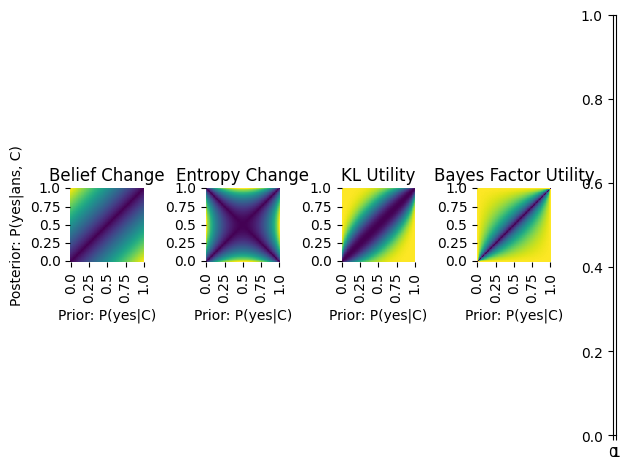

In [ ]:
def make_df_for_heatmap(f):
    n = 100
    priors = np.arange(0, 1+1/n, 1/n)
    posteriors = np.arange(0, 1+1/n, 1/n)
    array = np.zeros((n+1, n+1))
    for i, q in enumerate(priors):
        for j, p in enumerate(posteriors):
            array[j][i] = f(p, q)

    df = pd.DataFrame(array, index=priors, columns=posteriors)
    return df

def make_heatmap(df, ax, metric, min, max, cmap="viridis"):
    g = sns.heatmap(
        df,
        ax=ax,
        vmin=min,
        vmax=max,
        xticklabels=25,
        yticklabels=25,
        cmap=cmap,
        square=True,
        cbar=False,
        cbar_kws={'shrink': 0.5}
        )
    g.invert_yaxis()
    g.set_xlabel("Prior: P(yes|C)")
    g.set_ylabel("Posterior: P(yes|ans, C)")
    g.set_title(metric)
    return g

# fig, axs = plt.subplots(1, 4, figsize=(9, 3))
gs = gridspec.GridSpec(1, 5, width_ratios=[5,5,5,5,0.2], height_ratios=[5])
# cbar_ax = fig.add_subplot(gs[:, -1])
# cbar = fig.colorbar(g.collections[0], cax=cbar_ax)

axs = [plt.subplot(gs[0, i]) for i in range(5)]
for ax, metric in zip(axs, ["Belief Change", "Entropy Change", "KL Utility", "Bayes Factor Utility"]):
    f = {
        "Belief Change": prior_posterior_distance,
        "KL Utility": kl_util,
         "Entropy Change": entropy_reduction,
         "Bayes Factor Utility": bf_utility_polar
    }[metric]
    df = make_df_for_heatmap(f)
    min = 0
    max = {
        "Entropy Change": 1,
        "Belief Change": 1,
        "KL Utility": 1,
        "KL": 1.2,
        "Cross Entropy": 2,
        "Bayes Factor Utility": 1
    }[metric]
    g = make_heatmap(df, ax, metric, min, max)

for ax in axs[1:]:
    ax.set_ylabel("")

# for ax in [axs.flatten()[3]]:
#     ax.figure.delaxes(ax.figure.axes[4])
cbar_ax = fig.add_subplot(gs[:, -1])
cbar = fig.colorbar(g.collections[0], cax=cbar_ax)

plt.tight_layout()

plt.savefig("/content/drive/MyDrive/relevance/figures/first_order.pdf")

# Plotting higher order beliefs

## Useful functions


In [29]:
def fit_beta_mode_concentration(mode, concentration):
    """
    Compute parameters from the mode and concentration following this parameterization:
    https://en.wikipedia.org/wiki/Beta_distribution#Mode_and_concentration
    """
    alpha = mode * (concentration-2) + 1
    beta = (1-mode) * (concentration-2) + 1
    return alpha, beta

def return_beta(a, b, mode_concentration=False):
    if mode_concentration:
        m, k = a, b
        a, b = fit_beta_mode_concentration(a, b)
    else:
        m = (a - 1) / (a + b - 2)
        k = a + b
    x = np.linspace(beta.ppf(0.01, a, b),
                    beta.ppf(0.99, a, b), 100)
    y = beta.pdf(x, a, b)
    to_return = pd.DataFrame(zip(x,y), columns=["p(yes)", "density"])
    to_return[["α", "β", "ω", "κ"]] = (a, b, m, k)
    return to_return

def plot_beta(a, b, ax, mode_concentration=False):
    if mode_concentration:
        a, b = fit_beta_mode_concentration(a, b)
    x = np.linspace(beta.ppf(0.01, a, b),
                    beta.ppf(0.99, a, b), 100)
    ax.plot(x, beta.pdf(x, a, b), label=f'α=2, β={b}')
    ax.set_ylim(0, 5)
    return ax

## Visualizing beta distributions by parameter

### Changing concentration for a fixed mode

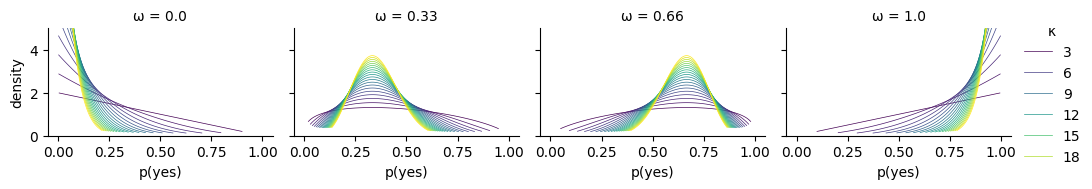

In [34]:
# fig = plt.figure(figsize=(6, 6))
modes = np.linspace(0, 1, 4)
concentrations = np.linspace(3, 20, 20)
dfs = []
for m, k in product(modes, concentrations):
    dfs.append(return_beta(m, k, mode_concentration=True))
df = pd.concat(dfs)
g = sns.relplot(kind="line", data=df, x="p(yes)", y="density", col="ω", hue="κ", height=2, aspect=1.3, linewidth=0.5, palette="viridis")
for ax in g.axes.flat:
    ax.set_ylim(0, 5)
    ax.set_title(ax.get_title()[:8], fontsize=10)
plt.savefig("/content/drive/MyDrive/relevance/figures/fixed_mode.pdf", bbox_inches="tight")

### Changing mode for a fixed concentration

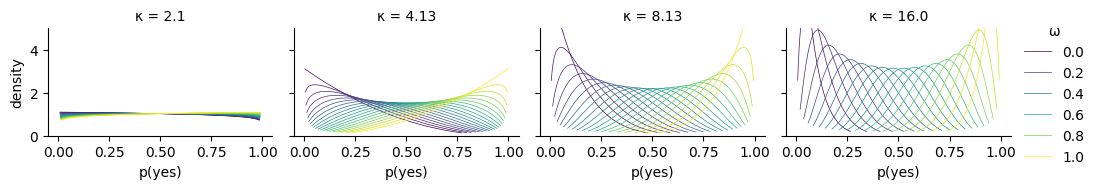

In [35]:
modes = np.linspace(0, 1, 20)
concentrations = np.geomspace(2.1, 16, 4)
dfs = []
for m, k in product(modes, concentrations):
    dfs.append(return_beta(m, k, mode_concentration=True))
df = pd.concat(dfs)
g = sns.relplot(kind="line", data=df, x="p(yes)", y="density", col="κ", hue="ω", height=2, aspect=1.3, linewidth=0.5, palette="viridis")
for ax in g.axes.flat:
    ax.set_ylim(0, 5)
    ax.set_title(ax.get_title()[:8], fontsize=10)

plt.savefig("/content/drive/MyDrive/relevance/figures/fixed_concentration.pdf", bbox_inches="tight")

### Changing `b` for fixed `a`

<ipython-input-29-56f3cc87cd6f>:15: RuntimeWarning: invalid value encountered in scalar divide
  m = (a - 1) / (a + b - 2)


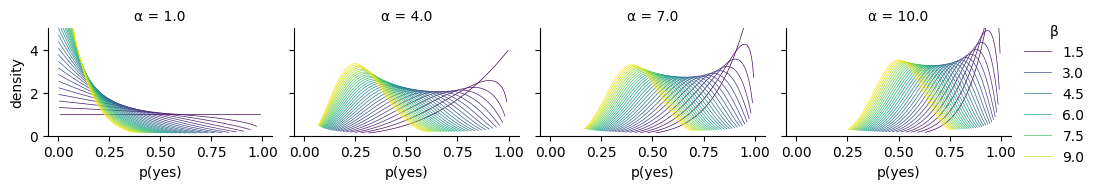

In [36]:
aa = np.linspace(1, 10, 4)
bb = np.linspace(1, 10, 30)
dfs = []
for a, b in product(aa, bb):
    dfs.append(return_beta(a, b, mode_concentration=False))
df = pd.concat(dfs)
g = sns.relplot(kind="line", data=df, x="p(yes)", y="density", col="α", hue="β", height=2, aspect=1.3, linewidth=0.5, palette="viridis")
for ax in g.axes.flat:
    ax.set_ylim(0, 5)
    ax.set_title(ax.get_title()[:8], fontsize=10)

plt.savefig("/content/drive/MyDrive/relevance/figures/fixed_a.pdf", bbox_inches="tight")

## Heatmaps

### Example: heatmap with the axes labeled with beta distributions

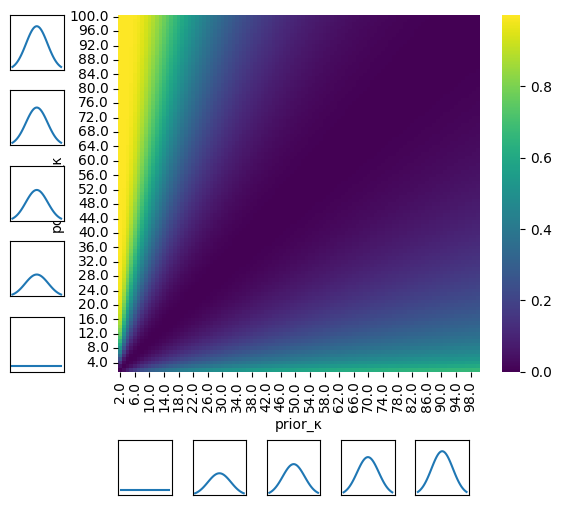

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

# Set up the gridspec
fig = plt.figure(figsize=(7, 6))
gs = gridspec.GridSpec(7, 8, width_ratios=[0.2, 0.05, 0.2, 0.2, 0.2, 0.2, 0.2, 0.3], height_ratios=[0.2, 0.2, 0.2, 0.2, 0.2, 0.1, 0.2])

# Create the dataframe for the heatmap
mode = 0.5
concentrations = np.linspace(2, 100, 99)
betas = []
for k in concentrations:
    a, b = fit_beta_mode_concentration(mode, k)
    betas.append((k, a, b))

df_met = pd.DataFrame(
    [(a, b, c, d, e, f) for (a, b, c), (d, e, f) in product(betas, betas)],
    columns=["_".join(x) for x in product(["prior", "posterior"], ["κ", "a", "b"])]
    )

df_met["kl_dirichlet"] = df_met.apply(
    lambda x: kl_util_dirichlet(
        [x["prior_a"], x["prior_b"]],
         [x["posterior_a"], x["posterior_b"]]),
    axis=1)

df_kl = df_met[["prior_κ", "posterior_κ", "kl_dirichlet"]].pivot(values="kl_dirichlet", columns="prior_κ", index="posterior_κ").iloc[::-1]

# Plot the heatmap in the center
ax_heatmap = plt.subplot(gs[0:5, 2:8])
g = sns.heatmap(df_kl, ax=ax_heatmap, cmap='viridis', annot=False, cbar=True)

# Create the dataframe for the x- and y-axes
concentrations = [2, 25, 50, 75, 100]
dfs = []
m = 0.5
for k in concentrations:
    dfs.append(return_beta(m, k, mode_concentration=True))
df_ax = pd.concat(dfs)

# Plot the plots on the left side
for i, k_value in enumerate([100, 75, 50, 25, 2]):
    ax_left = plt.subplot(gs[i, 0])
    g = sns.lineplot(x='p(yes)', y='density', data=df_ax[df_ax['κ'] == k_value], ax=ax_left)
    g.set_ylim((0, 10))
    ax_left.set(xlabel='', ylabel='', xticklabels=[], yticklabels=[])
    ax_left.tick_params(axis='both', which='both', length=0)  # Remove tick marks


# Plot the plots along the bottom
for i, k_value in enumerate([2, 25, 50, 75, 100]):
    ax_bottom = plt.subplot(gs[6, i + 2])
    g = sns.lineplot(x='p(yes)', y='density', data=df_ax[df_ax['κ'] == k_value], ax=ax_bottom)
    g.set_ylim((0, 10))
    ax_bottom.set(xlabel='', ylabel='', xticklabels=[], yticklabels=[])
    ax_bottom.tick_params(axis='both', which='both', length=0)  # Remove tick marks


plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.4, hspace=0.4)


### Redo this example but changing the mode

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.ticker import StrMethodFormatter
import seaborn as sns


def make_gridspec():
    # Set up the gridspec
    fig = plt.figure(figsize=(7, 6))
    gs = gridspec.GridSpec(7, 8, width_ratios=[0.2, 0.05, 0.2, 0.2, 0.2, 0.2, 0.2, 0.3], height_ratios=[0.2, 0.2, 0.2, 0.2, 0.2, 0.1, 0.2])
    return gs


def df_for_heatmap(concentration_prior, concentration_posterior, f_metric):
    modes = np.linspace(0, 1, 21)
    betas_prior = []
    betas_posterior = []
    for m in modes:
        a, b = fit_beta_mode_concentration(m, concentration_prior)
        betas_prior.append((m, a, b))
        a, b = fit_beta_mode_concentration(m, concentration_posterior)
        betas_posterior.append((m, a, b))

    df_met = pd.DataFrame(
        [(a, b, c, d, e, f) for (a, b, c), (d, e, f) in product(betas_prior, betas_posterior)],
        columns=["_".join(x) for x in product(["prior", "posterior"], ["ω", "a", "b"])]
        )

    df_met[f_metric.__name__] = df_met.apply(
        lambda x: f_metric(
            [x["prior_a"], x["prior_b"]],
            [x["posterior_a"], x["posterior_b"]]),
        axis=1)

    df_met = df_met[["prior_ω", "posterior_ω", f_metric.__name__]].pivot(values=f_metric.__name__, columns="prior_ω", index="posterior_ω").iloc[::-1]
    return df_met


# def plot_heatmap(gridspec, df_metric):
#     ax_heatmap = plt.subplot(gridspec[0:5, 2:8])
#     g = sns.heatmap(df_metric, ax=ax_heatmap, cmap='viridis', annot=False, cbar=True, vmin=0, vmax=1)
#     return g

def plot_heatmap(df_metric, ax, vmax=1, cbar=True):
    g = sns.heatmap(df_metric, ax=ax, cmap='viridis', annot=False, cbar=cbar, vmin=0, vmax=vmax)
    return g


def make_df_for_axes(concentration):
    modes = [1, 0.75, 0.5, 0.25, 0]
    dfs = []
    for m in modes:
        dfs.append(return_beta(m, concentration, mode_concentration=True))
    df_ax = pd.concat(dfs)
    return df_ax


def plot_axes(gridspec, df_for_axes_prior, df_for_axes_posterior):
    # Plot the plots on the left side
    for i, m_value in enumerate([1, 0.75, 0.5, 0.25, 0]):
        ax_left = plt.subplot(gridspec[i, 0])
        g = sns.lineplot(x='p(yes)', y='density', data=df_for_axes_prior[df_for_axes_prior['ω'] == m_value], ax=ax_left)
        g.set_ylim((0, 10))
        ax_left.set(xlabel='', ylabel='', xticklabels=[], yticklabels=[])
        ax_left.tick_params(axis='both', which='both', length=0)  # Remove tick marks

    # Plot the plots along the bottom
    for i, k_value in enumerate([0, 0.25, 0.5, 0.75, 1]):
        ax_bottom = plt.subplot(gridspec[6, i + 2])
        g = sns.lineplot(x='p(yes)', y='density', data=df_for_axes_posterior[df_for_axes_posterior['ω'] == k_value], ax=ax_bottom)
        g.set_ylim((0, 10))
        ax_bottom.set(xlabel='', ylabel='', xticklabels=[], yticklabels=[])
        ax_bottom.tick_params(axis='both', which='both', length=0)  # Remove tick marks

def plot_axis(df, axs):
    for ax, m_value in zip(axs, [0, 0.25, 0.5, 0.75, 1]):
        g = sns.lineplot(x='p(yes)', y='density', data=df[df['ω'] == m_value], ax=ax)
        g.set_ylim((0, 10))
        ax.set(xlabel='', ylabel='', xticklabels=[], yticklabels=[])
        ax.tick_params(axis='both', which='both', length=0)



# # =========== MAIN =============

# CONC_prior = 5
# CONC_posterior = 10
# gs = make_gridspec()
# ax_heatmap = plt.subplot(gs[0:5, 2:8])
# df_kl = df_for_heatmap(concentration_prior=CONC_prior, concentration_posterior=CONC_posterior, f_metric=kl_util_dirichlet)
# g = plot_heatmap(df_kl, ax=ax_heatmap)
# df_ax_prior = make_df_for_axes(concentration=CONC_prior)
# df_ax_posterior = make_df_for_axes(concentration=CONC_posterior)
# plot_axes(gs, df_ax_prior, df_ax_posterior)
# plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.4, hspace=0.4)

Let's take this heatmap and repeat multiple times

In [ ]:
from math import ceil

def make_heatmap_grid(metric, title, vmax=1, prior_posn=(-8, -0.2), posterior_posn=(-18.5, 0.5), title_posn=(-8, 1.05)):
    fig = plt.figure(figsize=(6, 6))

    n_conc = 4
    gs = gridspec.GridSpec(n_conc, n_conc+1, width_ratios=[1] * n_conc + [0.3], height_ratios=[1] * n_conc)
    concentrations = np.geomspace(2, 128, n_conc)

    def plot_heatmap(df_metric, ax, cbar=True):
        g = sns.heatmap(df_metric, ax=ax, cmap='viridis', annot=False, cbar=cbar, vmin=0, vmax=vmax)
        return g

    for i, conc_prior in enumerate(concentrations):
        for j, conc_posterior in enumerate(concentrations):
            ax = plt.subplot(gs[n_conc-i-1,j])
            # ax.xaxis.set_major_formatter(FormatStrFormatter('%0.1f'))
            df = df_for_heatmap(concentration_prior=conc_prior, concentration_posterior=conc_posterior, f_metric=metric)
            g = plot_heatmap(df, ax=ax, cbar=False)
            # g = make_heatmap(df_kl, ax=ax)
            if j > 0:
                ax.set_yticks([])
                ax.set_ylabel("")
            else:
                ax.set_ylabel(f"κ={round(conc_prior)}\nω=...")
                ax.set_yticklabels(["{:.1f}".format(float(t.get_text())) for t in ax.get_yticklabels()])
            if i > 0:
                ax.set_xticks([])
                ax.set_xlabel("")
            else:
                ax.set_xlabel(f"ω=...\nκ={round(conc_posterior)}")
                ax.set_xticklabels(["{:.1f}".format(float(t.get_text())) for t in ax.get_xticklabels()])
            # ax.xaxis.set_major_formatter(StrMethodFormatter('{x:.1f}'))


    cbar_ax = fig.add_subplot(gs[:, -1])
    cbar = fig.colorbar(g.collections[0], cax=cbar_ax)
    plt.text(posterior_posn[0], posterior_posn[1], 'Posterior', va='center', ha='center', rotation=90, fontsize=16)
    plt.text(prior_posn[0], prior_posn[1], 'Prior', va='center', ha='center', fontsize=16)
    plt.text(title_posn[0], title_posn[1], title, va='center', ha='center', fontsize=16)

    plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.2, wspace=0.2, hspace=0.2)

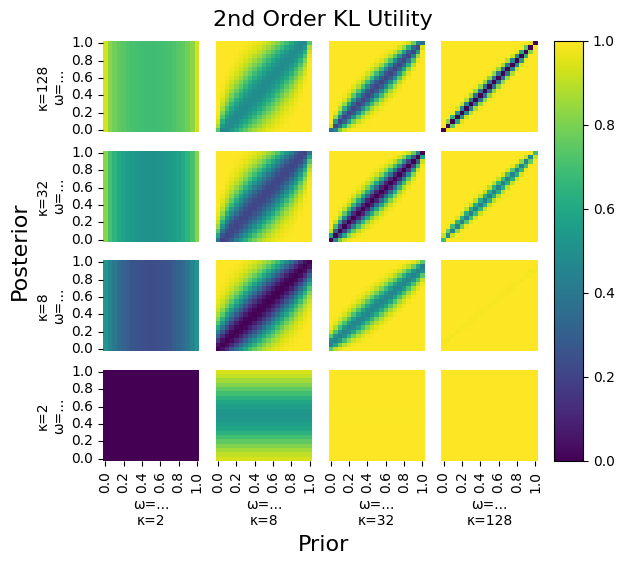

In [ ]:
make_heatmap_grid(metric=kl_util_dirichlet, title="2nd Order KL Utility")
plt.savefig("/content/drive/MyDrive/relevance/figures/second_order_kl.pdf", bbox_inches="tight")

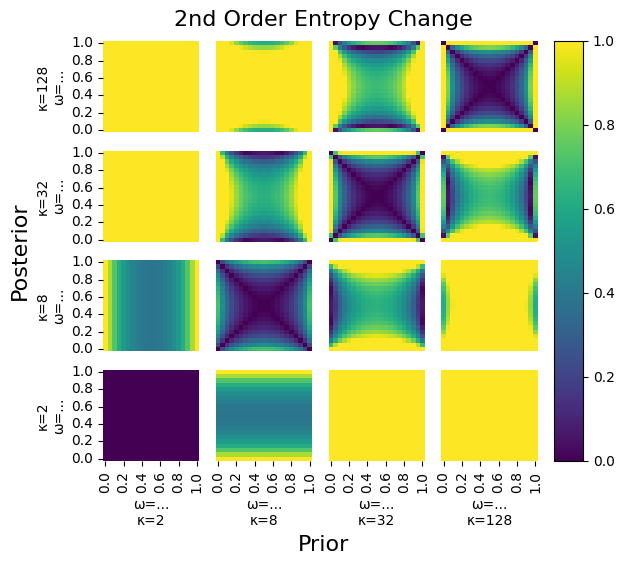

In [ ]:
make_heatmap_grid(metric=entropy_change_dirichlet, title="2nd Order Entropy Change")
plt.savefig("/content/drive/MyDrive/relevance/figures/second_order_ec.pdf", bbox_inches="tight")

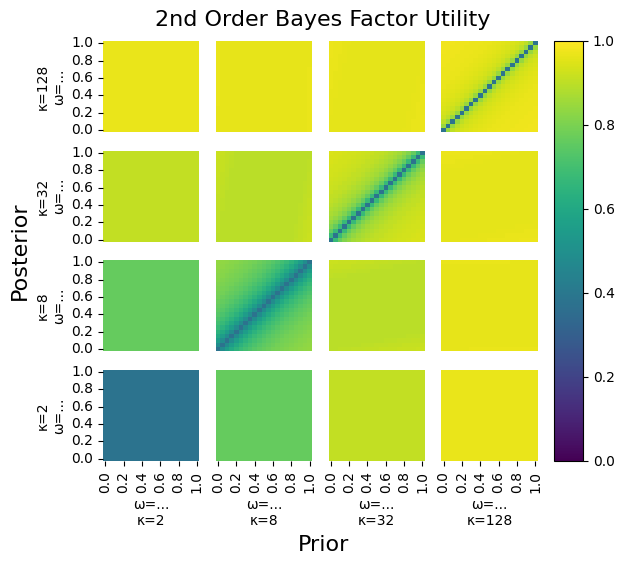

In [ ]:
make_heatmap_grid(metric=beta_bayes_factor_util, title="2nd Order Bayes Factor Utility")
plt.savefig("/content/drive/MyDrive/relevance/figures/second_order_bf.pdf", bbox_inches="tight")

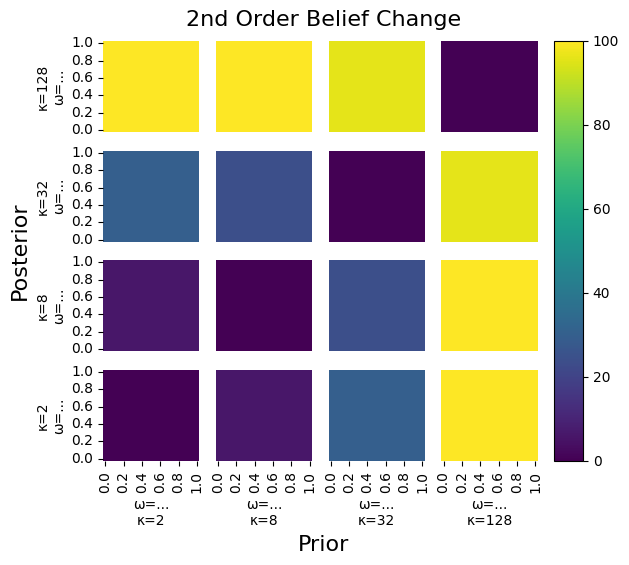

In [ ]:
make_heatmap_grid(metric=beta_belief_change, vmax=100, prior_posn=(-8, -20), posterior_posn=(-18.5, 50), title_posn=(-8, 105), title="2nd Order Belief Change")
plt.savefig("/content/drive/MyDrive/relevance/figures/second_order_bc.pdf", bbox_inches="tight")

Now we do this with the little axes plots

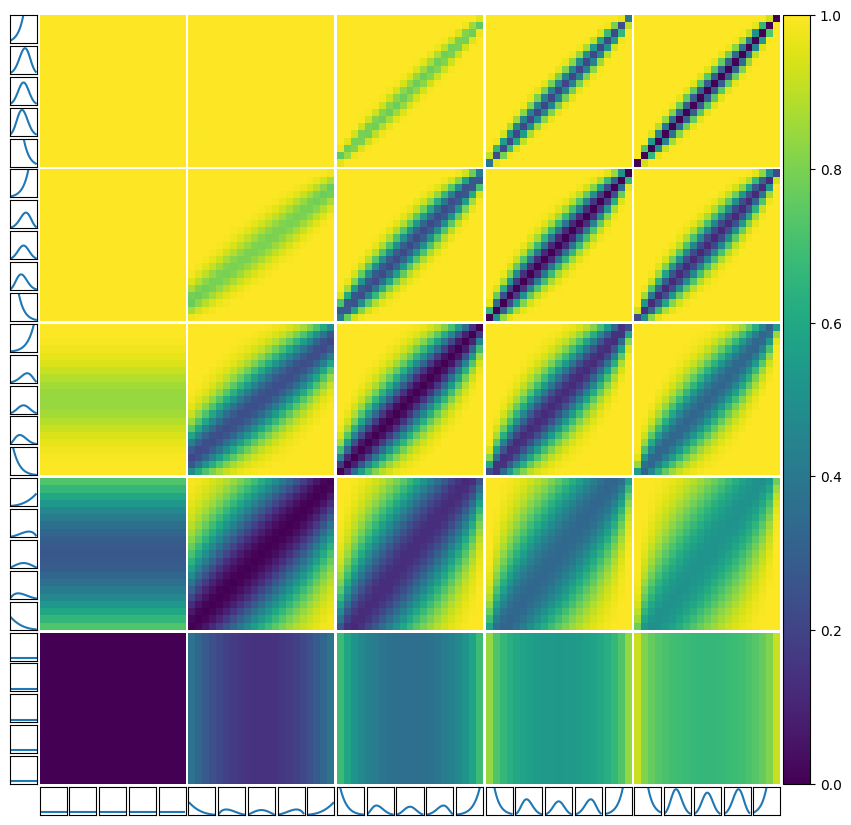

In [ ]:
def make_heatmap_grid(f_metric, vmax=1):
    fig = plt.figure(figsize=(10,10))

    n_conc = 5
    n_ax_labels = 5
    gs = gridspec.GridSpec(1+n_ax_labels*n_conc, 2+n_ax_labels*(n_conc), width_ratios=[1] * (1+n_ax_labels*n_conc) + [1], height_ratios=[1] * (1+n_ax_labels*n_conc))
    concentrations = np.geomspace(2, 100, n_conc)

    for i, conc_prior in enumerate(concentrations):
        for j, conc_posterior in enumerate(concentrations):
            ax = plt.subplot(
                gs[n_ax_labels*(n_conc-j-1):
                n_ax_labels*(n_conc-j),
                1+n_ax_labels*i:
                n_ax_labels*(i+1)+1]
                )
            ax.xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
            df_kl = df_for_heatmap(concentration_prior=conc_prior, concentration_posterior=conc_posterior, f_metric=f_metric)
            g = plot_heatmap(df_kl, ax=ax, vmax=vmax, cbar=False)
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_xlabel("")
            ax.set_ylabel("")


    for i, conc_prior in enumerate(concentrations):
        df_ax = make_df_for_axes(conc_prior)
        axs = [plt.subplot(gs[n_ax_labels*(n_conc-i)-j-1, 0]) for j in range(n_ax_labels)]
        plot_axis(df_ax, axs)

        axs = [plt.subplot(gs[-1, 1+n_ax_labels*i+j]) for j in range(n_ax_labels)]
        plot_axis(df_ax, axs)


    cbar_ax = fig.add_subplot(gs[:-1, -1])
    cbar = fig.colorbar(g.collections[0], cax=cbar_ax)
    plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.1, hspace=0.1)

make_heatmap_grid(kl_util_dirichlet)
plt.savefig("/content/drive/MyDrive/relevance/figures/kl_2order.pdf")

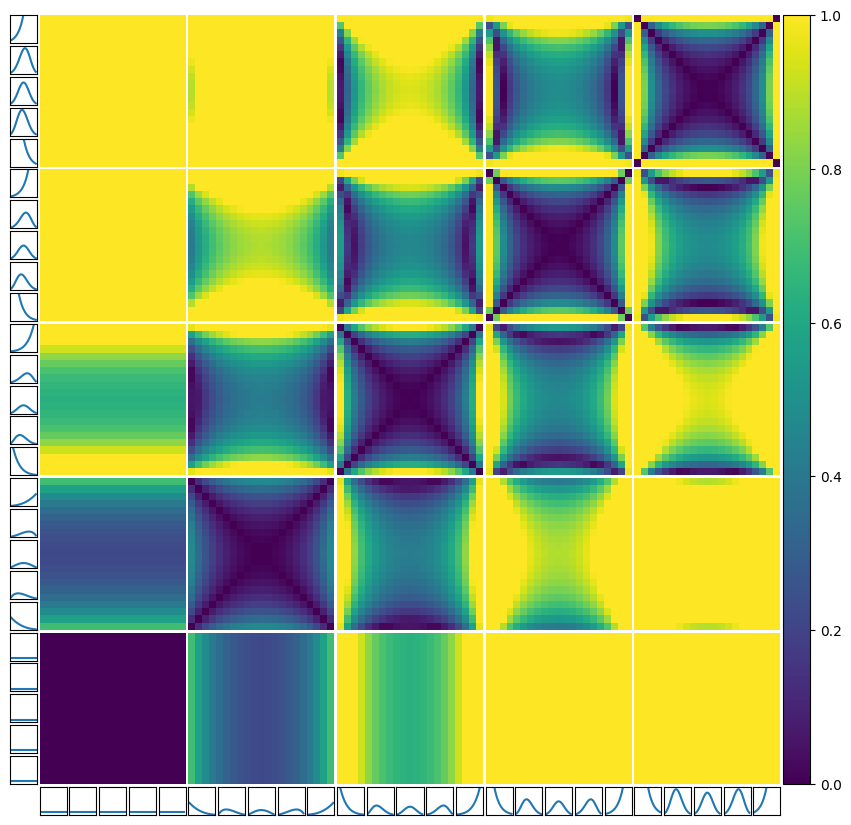

In [ ]:
make_heatmap_grid(entropy_change_dirichlet)
plt.savefig("/content/drive/MyDrive/relevance/figures/entropy_2order.pdf")

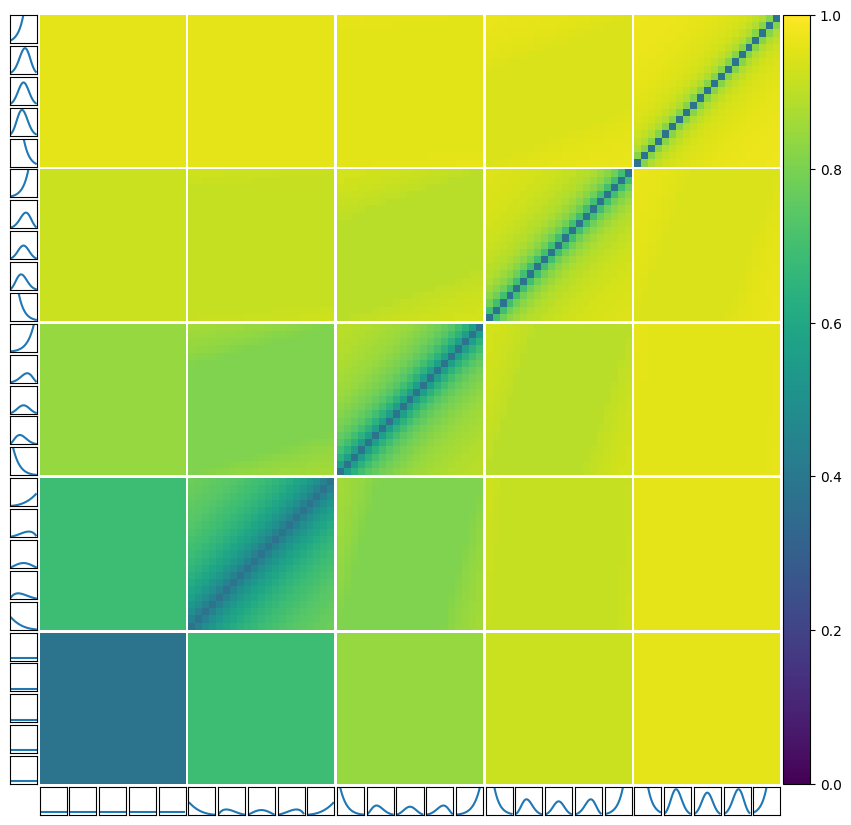

In [ ]:
make_heatmap_grid(beta_bayes_factor_util, vmax=1)
plt.savefig("/content/drive/MyDrive/relevance/figures/bf_2order.pdf")

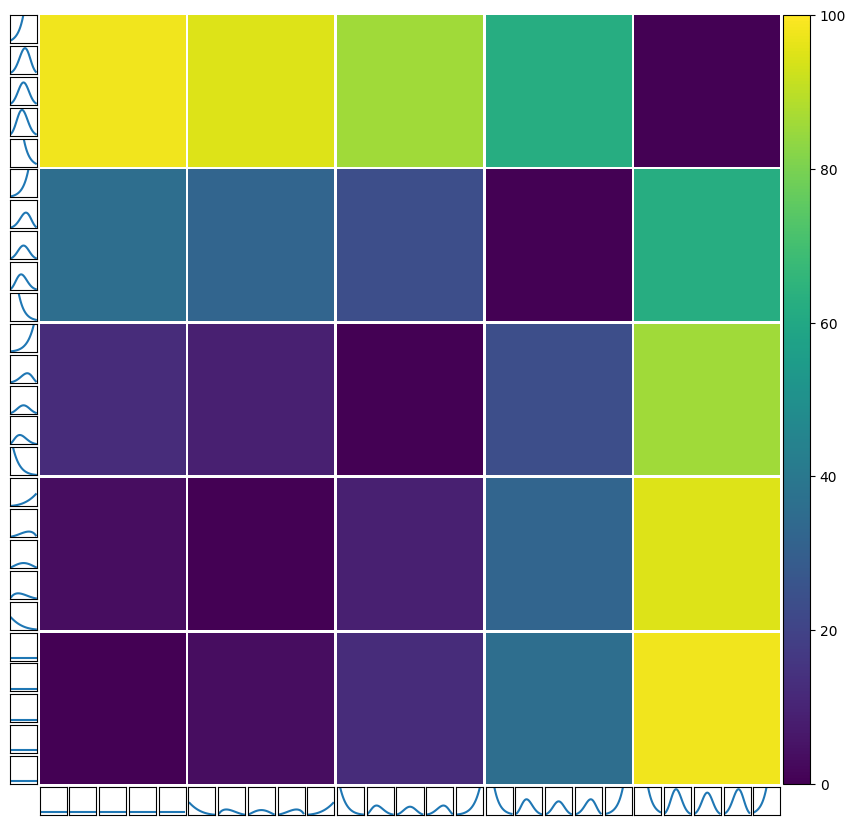

In [ ]:
make_heatmap_grid(beta_belief_change, vmax=100)
plt.savefig("/content/drive/MyDrive/relevance/figures/bc_2order.pdf")

# Old crap related to heatmaps

In [ ]:
# We'll just look at the mode of 0.5
mode = 0.5
concentrations = np.linspace(2, 100, 99)
betas = []
for k in concentrations:
    a, b = fit_beta_mode_concentration(mode, k)
    betas.append((k, a, b))

df = pd.DataFrame(
    [(a, b, c, d, e, f) for (a, b, c), (d, e, f) in product(betas, betas)],
    columns=["_".join(x) for x in product(["prior", "posterior"], ["κ", "a", "b"])]
    )

df

,prior_κ,prior_a,prior_b,posterior_κ,posterior_a,posterior_b
0,2.0,1.0,1.0,2.0,1.0,1.0
1,2.0,1.0,1.0,3.0,1.5,1.5
2,2.0,1.0,1.0,4.0,2.0,2.0
3,2.0,1.0,1.0,5.0,2.5,2.5
4,2.0,1.0,1.0,6.0,3.0,3.0
...,...,...,...,...,...,...
9796,100.0,50.0,50.0,96.0,48.0,48.0
9797,100.0,50.0,50.0,97.0,48.5,48.5
9798,100.0,50.0,50.0,98.0,49.0,49.0
9799,100.0,50.0,50.0,99.0,49.5,49.5


<Axes: xlabel='prior_κ', ylabel='posterior_κ'>

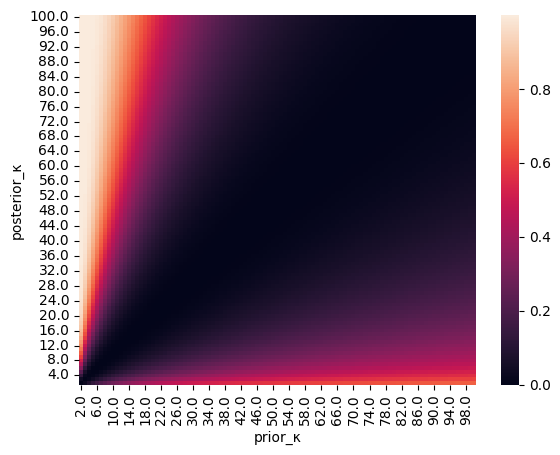

In [ ]:
df["kl_dirichlet"] = df.apply(
    lambda x: kl_util_dirichlet(
        [x["prior_a"], x["prior_b"]],
         [x["posterior_a"], x["posterior_b"]]),
    axis=1)

df_kl = df[["prior_κ", "posterior_κ", "kl_dirichlet"]].pivot(values="kl_dirichlet", columns="prior_κ", index="posterior_κ").iloc[::-1]
sns.heatmap(df_kl)

<Axes: xlabel='prior_κ', ylabel='posterior_κ'>

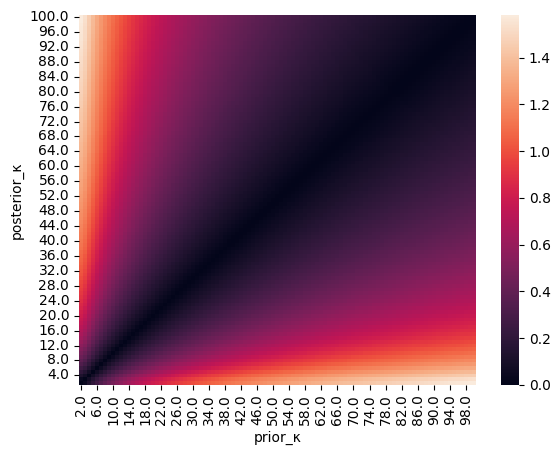

In [ ]:
df["entropy_change_dirichlet"] = df.apply(
    lambda x: entropy_change_dirichlet(
        [x["prior_a"], x["prior_b"]],
         [x["posterior_a"], x["posterior_b"]]),
    axis=1)

df_er = df[["prior_κ", "posterior_κ", "entropy_change_dirichlet"]].pivot(values="entropy_change_dirichlet", columns="prior_κ", index="posterior_κ").iloc[::-1]
sns.heatmap(df_er)

In [ ]:
df["beta_bayes_factor"] = df.apply(
    lambda x: beta_bayes_factor(
        [x["prior_a"], x["prior_b"]],
         [x["posterior_a"], x["posterior_b"]]),
    axis=1)

df_bbf = df[["prior_k", "posterior_k", "beta_bayes_factor"]].pivot(values="beta_bayes_factor", columns="prior_k", index="posterior_k").iloc[::-1]
sns.heatmap(df_bbf)

KeyError: "['prior_k', 'posterior_k'] not in index"

In [ ]:
df["beta_belief_change"] = df.apply(
    lambda x: beta_belief_change(
        [x["prior_a"], x["prior_b"]],
         [x["posterior_a"], x["posterior_b"]]),
    axis=1)

df_bbc = df[["prior_k", "posterior_k", "beta_belief_change"]].pivot(values="beta_belief_change", columns="prior_k", index="posterior_k").iloc[::-1]
sns.heatmap(df_bbc)

In [ ]:
# We'll just look at a concentration of 10
modes = np.linspace(0, 1, 101)
concentration = 10
betas = []
for m in modes:
    a, b = fit_beta_mode_concentration(m, concentration)
    betas.append((m, a, b))

df = pd.DataFrame(
    [(a, b, c, d, e, f) for (a, b, c), (d, e, f) in product(betas, betas)],
    columns=["_".join(x) for x in product(["prior", "posterior"], ["ω", "a", "b"])]
    )

for fun in [kl_util_dirichlet, entropy_change_dirichlet, beta_bayes_factor, beta_belief_change]:
    metric_name = fun.__name__
    df[metric_name] = df.apply(
        lambda x: fun(
            [x["prior_a"], x["prior_b"]],
             [x["posterior_a"], x["posterior_b"]]),
        axis=1)

df = pd.DataFrame(
        df.set_index(["prior_ω", "prior_a", "prior_b", "posterior_a", "posterior_b", "posterior_ω"]).stack(), columns=["score"]
    ).reset_index().rename({"level_6": "metric"}, axis=1)

def draw_heatmap(*args, **kwargs):
    data = kwargs.pop('data')
    d = data.pivot(index=args[1], columns=args[0], values=args[2]).iloc[::-1]
    sns.heatmap(d, **kwargs)

fg = sns.FacetGrid(df, col='metric')
fg.map_dataframe(draw_heatmap, 'prior_ω', 'posterior_ω', 'score', cbar=False)

modes = np.linspace(0, 1, 4)
concentration = 10
dfs = []
for m, k in product(modes, concentrations):
    dfs.append(return_beta(m, k, mode_concentration=True))
df = pd.concat(dfs)
g = sns.relplot(kind="line", data=df, x="p(yes)", y="density", col="ω")
for ax in g.axes.flat:
    ax.set_ylim(0, 5)
